## analyze data

In [3]:
import pandas as pd
import seaborn as sns
from pathlib import Path
datafolder = Path('../test_data')

In [8]:
cars = pd.read_csv(datafolder / 'cars.csv')
cars = cars[['aspiration', 'carbody', 'enginesize', 'curbweight', 'price']]
cars.head(5)

,aspiration,carbody,enginesize,curbweight,price
0,std,convertible,130,2548,13495.0
1,std,convertible,130,2548,16500.0
2,std,hatchback,152,2823,16500.0
3,std,sedan,109,2337,13950.0
4,std,sedan,136,2824,17450.0


In [10]:
cars_melted = pd.melt(
    cars,
    id_vars = 'price',
    value_vars = ['enginesize', 'curbweight'],
    var_name = 'feature', value_name='feature_value'
)
cars_melted.head(3)

,price,feature,feature_value
0,13495.0,enginesize,130
1,16500.0,enginesize,130
2,16500.0,enginesize,152


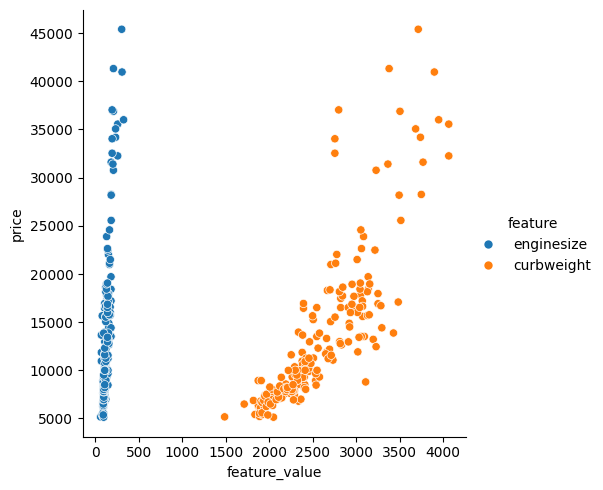

In [11]:
sns.relplot(
    data=cars_melted,
    y='price',
    x='feature_value',
    hue='feature',
)


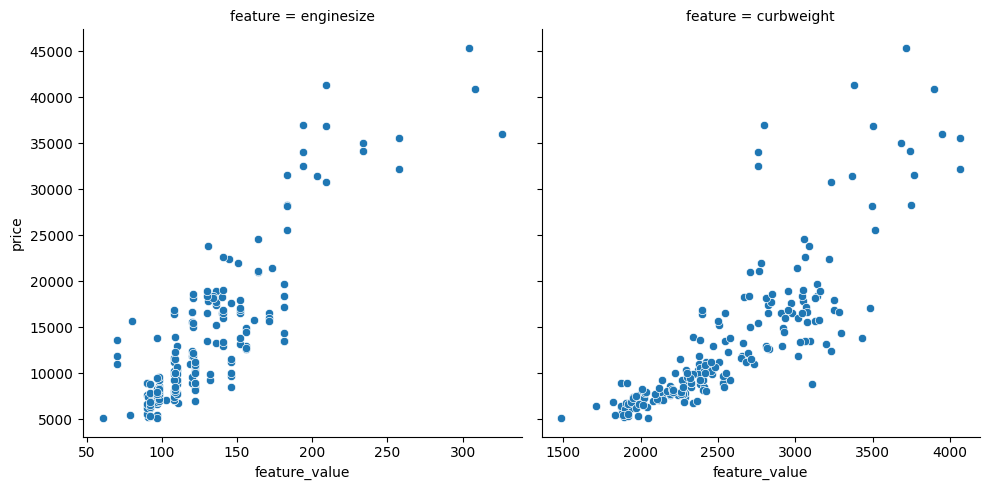

In [13]:
sns.relplot(
    data=cars_melted,
    y='price',
    x='feature_value',
    col='feature',
    facet_kws={'sharex':False}
)

In [47]:
import sqlite3
'https://sqlitebrowser.org/dl/'
fires_con = sqlite3.connect(datafolder / 'FPA_FOD_20170508.sqlite')
fires = pd.read_sql_query(
    '''SELECT STATE, FIRE_YEAR, DATETIME(DISCOVERY_DATE) AS DISCOVERY_DATE,
    DATETIME(CONT_DATE) AS CONTAIN_DATE, FIRE_NAME, FIRE_SIZE, LATITUDE, LONGITUDE
    FROM Fires''',
    fires_con
)


In [48]:
fires.columns = fires.columns.str.lower()
fires[['discovery_date', 'contain_date']] = \
    fires[['discovery_date', 'contain_date']].apply(pd.to_datetime)
fires = fires.rename(columns={
    'fire_size':'acres_burned'
})
fires['fire_month'] = fires['discovery_date'].dt.month
fires['days_burning'] = (fires['contain_date'] - fires['discovery_date']).dt.days
# fires = fires.dropna(subset=['days_burning'])
fires

,state,fire_year,discovery_date,contain_date,fire_name,acres_burned,latitude,longitude,fire_month,days_burning
0,CA,2005,2005-02-02,2005-02-02,FOUNTAIN,0.10,40.036944,-121.005833,2,0.0
1,CA,2004,2004-05-12,2004-05-12,PIGEON,0.25,38.933056,-120.404444,5,0.0
2,CA,2004,2004-05-31,2004-05-31,SLACK,0.10,38.984167,-120.735556,5,0.0
3,CA,2004,2004-06-28,2004-07-03,DEER,0.10,38.559167,-119.913333,6,5.0
4,CA,2004,2004-06-28,2004-07-03,STEVENOT,0.10,38.559167,-119.933056,6,5.0
...,...,...,...,...,...,...,...,...,...,...
1880460,CA,2015,2015-09-26,2015-09-26,ODESSA 2,0.01,40.481637,-122.389375,9,0.0
1880461,CA,2015,2015-10-05,NaT,None,0.20,37.617619,-120.938570,10,NaN
1880462,CA,2015,2015-05-02,NaT,None,0.10,37.617619,-120.938570,5,NaN
1880463,CA,2015,2015-10-14,NaT,None,2.00,37.672235,-120.898356,10,NaN


In [50]:
fires.groupby('state')[['acres_burned','days_burning']].mean().head()


,acres_burned,days_burning
state,,
AK,2509.779198,11.100149
AL,13.828230,0.155161
AR,16.072761,0.178034
AZ,77.901837,1.080205
CA,67.242725,1.053010


In [51]:
fires.groupby(by=['state', 'fire_year', 'fire_month'])[['acres_burned','days_burning']].max().head()

acres_burned  days_burning
state fire_year fire_month                            
AK    1992      4                    3.5          13.0
                5                 1410.0          54.0
                6                48087.0          82.0
                7                35090.0          77.0
                8                 2870.0          46.0

In [55]:
yearly_group = fires.groupby('fire_year', as_index=False)
yearly_group[['acres_burned', 'days_burning']].sum().head()


,fire_year,acres_burned,days_burning
0,1992,2199958.001,21640.0
1,1993,2191696.003,15362.0
2,1994,4116675.529,38946.0
3,1995,2049585.058,24458.0
4,1996,6005155.709,27628.0


## pivot tables

In [59]:
states = ['AK', 'CA','ID', 'TX']
top_states = fires.groupby(by=['state', 'fire_year'], as_index=False)[['acres_burned', 'days_burning']].sum()
top_states = top_states.query('state in @states')
top_states.pivot(index='fire_year', columns='state', values='acres_burned').head(3)


state,AK,CA,ID,TX
fire_year,,,,
1992,142717.4,296439.8,684658.9,33610.3
1993,687191.5,321495.3,7978.2,116873.7
1994,261964.9,407944.7,729029.6,70917.5


<Axes: xlabel='fire_year'>

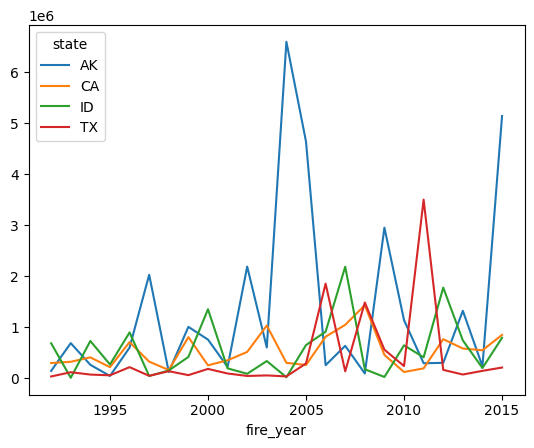

In [60]:
top_states.pivot(index='fire_year', columns='state', values='acres_burned').plot()

<Axes: xlabel='fire_year'>

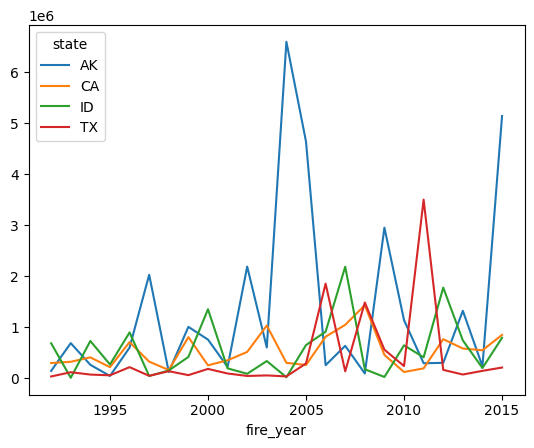

In [ ]:
top_states = fires.query('state in @states')
top_states = top_states.pivot_table(index='fire_year', columns='state', values='acres_burned', aggfunc='sum')
top_states.plot()

## bins

In [64]:
fires_filtered = fires.query('fire_year == 2010 and days_burning > 0').dropna()
fires_filtered.head()


,state,fire_year,discovery_date,contain_date,fire_name,acres_burned,latitude,longitude,fire_month,days_burning
1145150,AK,2010,2010-06-03,2010-06-10,HIDDEN LAKE,0.1,62.789166,-141.310837,6,7.0
1145152,AK,2010,2010-04-24,2010-04-25,THE SHOOTING RANGE,1.2,64.791946,-147.689163,4,1.0
1145153,AK,2010,2010-04-24,2010-04-26,ANDERSON,1.5,61.716667,-148.866669,4,2.0
1145154,AK,2010,2010-04-28,2010-05-05,FOURMILE TRAIL,16.8,64.156944,-145.740829,4,7.0
1145157,AK,2010,2010-05-07,2010-05-16,LOU YOUNG,2.0,61.285000,-149.930557,5,9.0


In [67]:
pd.cut(fires_filtered.acres_burned, bins=4,
labels=['A','B','C','D']).value_counts()


acres_burned
A    6827
B       3
C       1
D       1
Name: count, dtype: int64

In [97]:
pd.qcut(
    fires_filtered.days_burning, 
    q=8, 
    duplicates='drop'
    )

1145150     (4.0, 10.0]
1145152    (0.999, 2.0]
1145153    (0.999, 2.0]
1145154     (4.0, 10.0]
1145157     (4.0, 10.0]
               ...     
1879728      (2.0, 4.0]
1879887    (0.999, 2.0]
1880168    (0.999, 2.0]
1880230    (0.999, 2.0]
1880370    (0.999, 2.0]
Name: days_burning, Length: 6832, dtype: category
Categories (4, interval[float64, right]): [(0.999, 2.0] < (2.0, 4.0] < (4.0, 10.0] < (10.0, 378.0]]

In [101]:
cars.nlargest(n=6, columns=['enginesize','price'])

,aspiration,carbody,enginesize,curbweight,price
49,std,sedan,326,3950,36000.0
73,std,sedan,308,3900,40960.0
74,std,hardtop,304,3715,45400.0
48,std,sedan,258,4066,35550.0
47,std,sedan,258,4066,32250.0
72,std,convertible,234,3685,35056.0


In [102]:
cars.nsmallest(n=6, columns=['enginesize','price'])

,aspiration,carbody,enginesize,curbweight,price
18,std,hatchback,61,1488,5151.0
55,std,hatchback,70,2380,10945.0
56,std,hatchback,70,2380,11845.0
57,std,hatchback,70,2385,13645.0
32,std,hatchback,79,1837,5399.0
58,std,hatchback,80,2500,15645.0


In [103]:
fires

,state,fire_year,discovery_date,contain_date,fire_name,acres_burned,latitude,longitude,fire_month,days_burning
0,CA,2005,2005-02-02,2005-02-02,FOUNTAIN,0.10,40.036944,-121.005833,2,0.0
1,CA,2004,2004-05-12,2004-05-12,PIGEON,0.25,38.933056,-120.404444,5,0.0
2,CA,2004,2004-05-31,2004-05-31,SLACK,0.10,38.984167,-120.735556,5,0.0
3,CA,2004,2004-06-28,2004-07-03,DEER,0.10,38.559167,-119.913333,6,5.0
4,CA,2004,2004-06-28,2004-07-03,STEVENOT,0.10,38.559167,-119.933056,6,5.0
...,...,...,...,...,...,...,...,...,...,...
1880460,CA,2015,2015-09-26,2015-09-26,ODESSA 2,0.01,40.481637,-122.389375,9,0.0
1880461,CA,2015,2015-10-05,NaT,None,0.20,37.617619,-120.938570,10,NaN
1880462,CA,2015,2015-05-02,NaT,None,0.10,37.617619,-120.938570,5,NaN
1880463,CA,2015,2015-10-14,NaT,None,2.00,37.672235,-120.898356,10,NaN


In [108]:
df = fires[['state', 'fire_year', 'acres_burned']] \
    .groupby(['state', 'fire_year']) \
    .sum()
df.pct_change()

acres_burned
state fire_year              
AK    1992                NaN
      1993           3.815051
      1994          -0.618789
      1995          -0.832183
      1996          12.620760
...                       ...
WY    2011           0.550678
      2012           2.577122
      2013          -0.887371
      2014          -0.857776
      2015           3.765953

[1214 rows x 1 columns]

In [113]:
df = fires.groupby('state', as_index=False)[['acres_burned', 'days_burning']].sum()
df['acres_rank'] = df.acres_burned.rank(ascending=False)

df.sort_values(by='acres_rank')
df

,state,acres_burned,days_burning,acres_rank
0,AK,3.223309e+07,96538.0,1.0
1,AL,9.205453e+05,4819.0,23.0
2,AR,5.089118e+05,1809.0,28.0
3,AZ,5.576681e+06,71677.0,9.0
4,CA,1.274586e+07,96780.0,3.0
5,CO,1.842309e+06,39324.0,15.0
6,CT,1.124331e+04,13.0,46.0
7,DC,3.250000e+01,1.0,52.0
8,DE,4.833650e+03,14.0,48.0
9,FL,4.436748e+06,19286.0,11.0
